# Expoloratory Data Analysis
In this notebook our main goal will be to extract insights from our data via the features already given along with some feature engineering along the way. Let's not forget that our main goal is to use NLP to gain insight into what makes a review useful, so after examining some basic features we'll dive into that.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import nltk
pd.set_option('display.max_columns', 500)
import re, string
import time
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandas.io.json import json_normalize
import readability
import syntok.segmenter as segmenter
import spacy
from spacy_cld import LanguageDetector
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Read in the resulting dataframe from the previous notebook

In [2]:
review_df = pd.read_csv('data/review_df.csv')
review_df.head()

/Users/jzmichal/opt/anaconda3/envs/yelpEnv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,stars,text,useful,nb_days,log_useful
0,5,Went in for a lunch. Steak sandwich was delici...,0.0,305.0,0.000000
1,1,"Really one of dirtiest places to eat,not sure ...",0.0,1158.0,0.000000
2,1,"Terrible place to eat and or drink, waitresses...",1.0,1628.0,0.693147
3,5,One of the best Italian restaurants in a city ...,1.0,1252.0,0.693147
4,5,A favorite amongst my girlfriends and family. ...,0.0,932.0,0.000000


Sample the data so that while tinkering with the features the runtime is managable. If you're reading this from github, the sampling will not be present. We'll also filter out extreme outliers that have more than 200 useful votes as well as reviews that have less than 5 characters, as these can't have that much substance. Finally we drop irrelevant columns.

In [3]:
#review_df = review_df.sample(frac=.005, replace = False,random_state=42)
review_df = review_df[review_df.useful < 200]
review_df = review_df[review_df["text"].apply(lambda t: len(t) > 5)]
review_df.stars = review_df.stars.astype(int)
review_df.text = review_df.text.astype(str)
review_df.shape

(3122168, 5)

In [4]:
nlp = spacy.load('en')
language_detector = LanguageDetector()
nlp.add_pipe(language_detector)
def only_English(text):
    try:
        doc = nlp(text)
    except:
        return False
    if 'en' in doc._.language_scores.keys():
        return doc._.language_scores['en'] > .9
    return False

In [5]:
review_df = review_df[review_df.text.apply(only_English)]
review_df.shape

(3102436, 5)

Here we'll take a peak at the distribution of our target variable, useful votes for a given review. We'll instead look at log useful, as evidently it evens out the distributions much more favorably. We'll also see later on that log useful correlates higher with nearly every relevant feature when compared with plain old useful.

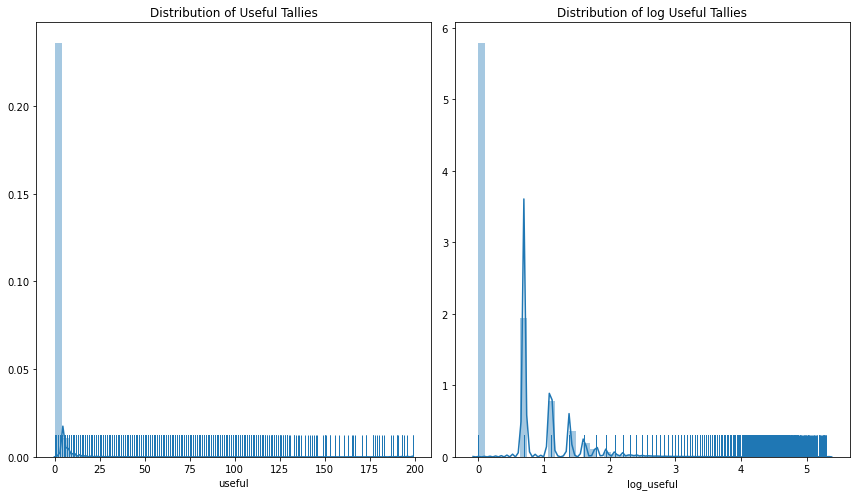

In [6]:
f, ax = plt.subplots(1,2,figsize = (12, 7))

ax0 = sns.distplot(review_df.useful, ax = ax[0], rug = True)
ax0.set_title("Distribution of Useful Tallies")


ax2 = sns.distplot(review_df.log_useful, rug = True, ax = ax[1])
ax2.set_title("Distribution of log Useful Tallies")

plt.tight_layout()

### Analysis of Age of Review vs Useful votes

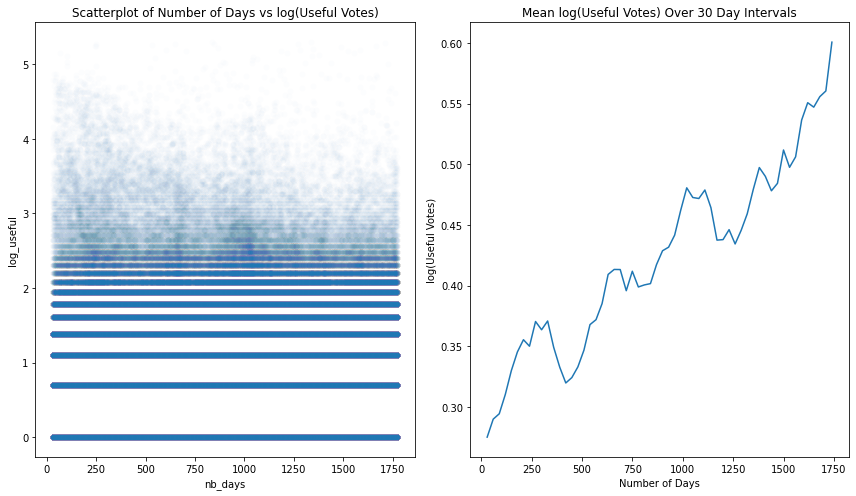

In [7]:
g1 = review_df.groupby(pd.cut(review_df.nb_days, np.arange(30, 1800, 30)))
d1 = g1["log_useful"].mean()
f, ax = plt.subplots(1,2, figsize = (12,7))

plt.subplot(121)
ax1 = sns.scatterplot(review_df.nb_days, review_df.log_useful, data = review_df, alpha = .01)
ax1.set_title("Scatterplot of Number of Days vs log(Useful Votes)")

ax2 = plt.subplot(122)
plt.plot(np.arange(30, 1770, 30), d1.values)
ax2.set_title("Mean log(Useful Votes) Over 30 Day Intervals")
ax2.set_ylabel("log(Useful Votes)")
ax2.set_xlabel("Number of Days")

plt.tight_layout()
plt.show()

### Distribution of stars 

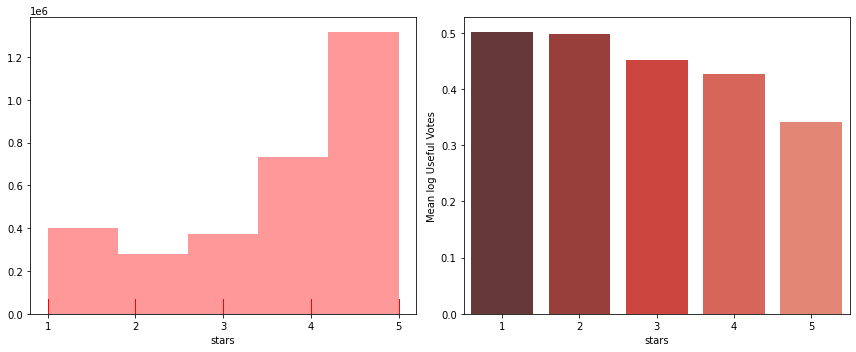

In [8]:
d2 = review_df.groupby(["stars"])["log_useful"].mean()

f, axes = plt.subplots(1,2,figsize = (12,5))

ax0 = sns.distplot(review_df.stars, kde=False, bins = 5, rug = True, color = "r", ax = axes[0])
ax0.set_xticks(np.arange(1,6))

ax1 = sns.barplot(d2.index, d2.values, ax = axes[1], palette="Reds_d")
ax1.set_ylabel("Mean log Useful Votes")
plt.tight_layout()

So it looks like our data contains a lot more 4 and 5 star reviews than anything else. Their appears to be a negative correlation between how useful a review is and the number of stars. We might be able to make sense of this by considering that a lot of positive 4 or 5 star reviews might be short and sweet, where as more negative reviews go in depth as to why they had a bad experience, thus having more information and making the review more useful.

Next we can categorize our data which will help us with some visualization aspects eventually, and give us an initial grouping of the data which we can eventually use to constrast with actual clustering algorithms. 

#### Label Encoding

Add some binary labels for data visualization purposes later on

In [9]:
def binary_label(rating):
    if rating == 0:
        return 0
    return 1
review_df["binary_useful"] = review_df.useful.apply(binary_label)

In [10]:
review_df.binary_useful.value_counts()

0    1902508
1    1199928
Name: binary_useful, dtype: int64

In [11]:
review_df[review_df.log_useful > 0].log_useful.describe()

count    1.199928e+06
mean     1.058094e+00
std      5.189102e-01
min      6.931472e-01
25%      6.931472e-01
50%      6.931472e-01
75%      1.386294e+00
max      5.298317e+00
Name: log_useful, dtype: float64

We know from statitistics that based off our box plots, the beginning of the outliers lies among $Q3 * 1.5 * IQR$ 
where Q3 represents the 75th percentile of the data and IQR is the Interquartile Range. Thus, for the below categorization, we'll define anything above this to be very useful, and all other reviews that received any amount of useful votes as plain old useful. 

In [12]:
def categorize(rating):
    if rating == 0:
        return 0
    elif rating < 1.44135829083:
        return 1
    else:
        return 2
review_df["useful_category"] = review_df.log_useful.apply(categorize)

In [13]:
review_df.useful_category.value_counts()

0    1902508
1    1010308
2     189620
Name: useful_category, dtype: int64

## NLP Pre-Processing and Feature Engineering

Now since the main idea of our notebook is to use NLP to determine what exactly makes a review useful, its about time that we started some NLP feature engineering to try to get some more insights into our data. We'll start off by cleaning the text data by removing stop words, punctuation, lowercase all the text, tokenizing the text (split it into words), part-of-speech (POS) tagging, and lemmatizing.



In [14]:
wpt = nltk.WordPunctTokenizer()
stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
def get_tag(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN
    
def clean_review(review):
    # lower case and remove special characters\whitespaces
    review = re.sub(r'[^a-zA-Z\s]', '', review, re.I|re.A)
    review = review.lower()
    review = review.strip()
    
    # tokenize document
    tokens = wpt.tokenize(review)
    # filter stopwords out of document
    review = [token for token in tokens if token not in stop_words]
    
    #get POS tags for the review
    pos_tags = pos_tag(review)
    
    # lemmatize review
    review = [WordNetLemmatizer().lemmatize(t[0], get_tag(t[1])) for t in pos_tags]
    
    # re-create document from filtered tokens
    review = ' '.join(review)
    return review

review_df["cleaned_review"] = review_df["text"].apply(lambda x: clean_review(x))

In [15]:
def rename_cols(key, d):
    """Add more annotation to column names for better understanding of the context of the NLP Features"""
    new_dict = {}
    for nested_key in d[key].keys():
        new_dict[key + " " + nested_key] = d[key][nested_key]
    return pd.Series(new_dict)
def unpack(text):
    """The readability API returns a nested dictionary of dictionaries, where each key in the original dictionary
    corresponds to a feature category e.g. sentence info, readability metric. This unpacks it and adds the new rows
    to the dataframe"""
    tokenized = '\n\n'.join(
     '\n'.join(' '.join(token.value for token in sentence)
        for sentence in paragraph)
     for paragraph in segmenter.analyze(text))
    nested_feature_dict = readability.getmeasures(tokenized, lang = 'en')
    row = []
    for k in nested_feature_dict.keys():
        row_fragment = rename_cols(k, nested_feature_dict)
        row.append(row_fragment)
    return pd.concat(row)

## NLP Feature Explanations

Here we'll import and use a library that has a ton of nlp features. Among the features, the categories are readability grades, sentence info, word usage, and how a sentence begins.

In order to get an understanding of what each of these nlp features mean, first we'll define some terms.

complex word: word having at least 3 syllables and is not a proper noun.

vocabulary: a set of all of the words used in a review.

long word: word containing more than 7 characters.

nominalization: is the use of a word which is not a noun (e.g., a verb, an adjective or an adverb) as a noun, or as the head of a noun phrase, with or without morphological transformation.

auxiliary verb: a verb used in forming the tenses, moods, and voices of other verbs.

conjunction: a word used to connect clauses or sentences or to coordinate words in the same clause (e.g. and, but, if ).

preposition: a word governing, and usually preceding, a noun or pronoun and expressing a relation to another word or element in the clause, as in “the man $on$ the platform,” “she arrived $after$ dinner,” “what did you do it $for$ ?”.

subordination: the process of linking two clauses in a sentence so that one clause is dependent on (or subordinate to) another.

wordtype: the term "type" refers to the number of distinct words in a review.

type_token_ratio: the total number of UNIQUE words (types) divided by the total number of words (tokens) in a given review (len(vocabulary) / words). 


Type vs Token: Token is an individual occurrence of a linguistic unit in speech or writing.  This is contrasted with type which is an abstract category, class, or category of linguistic item or unit.  Type is different from the number of actual occurrences which would be known as tokens. The sentence "a good wine is a wine that you like" contains nine tokens, but only seven types, as "a" and "wine" are repeated.

In [16]:
#Add the readability features to our dataframe
import time
start = time.time()
review_df = review_df.merge(review_df.text.apply(unpack), left_index = True, right_index = True)
end = time.time()
print(end - start)

36994.78072690964


### Sentiment Analysis
Next we'll apply NLTK's SentimentIntensityAnalyzer, which gives us four features. A negative, positive, neutral, and compound (all of these added up together) rating of each review's text.

In [17]:
sid = SentimentIntensityAnalyzer()
print(review_df.shape)
sentiments = review_df["cleaned_review"].apply(lambda x: sid.polarity_scores(x))
sentiments_df = json_normalize(sentiments)
sentiments_df.head()

(3102436, 43)


/Users/jzmichal/opt/anaconda3/envs/yelpEnv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,neg,neu,pos,compound
0,0.000,0.424,0.576,0.9896
1,0.288,0.605,0.107,-0.5965
2,0.495,0.409,0.096,-0.9124
3,0.000,0.711,0.289,0.9246
4,0.042,0.604,0.355,0.9944


In [18]:
#merge new feature dataframe with original review dataframe
review_df.reset_index(inplace = True, drop = True)
sentiments_df.reset_index(inplace = True, drop = True)
review_df = pd.concat((review_df, sentiments_df), axis = 1)
review_df.shape

(3102436, 47)

In [19]:
review_df.head()

,stars,text,useful,nb_days,log_useful,binary_useful,useful_category,cleaned_review,readability grades Kincaid,readability grades ARI,readability grades Coleman-Liau,readability grades FleschReadingEase,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,readability grades DaleChallIndex,sentence info characters_per_word,sentence info syll_per_word,sentence info words_per_sentence,sentence info sentences_per_paragraph,sentence info type_token_ratio,sentence info characters,sentence info syllables,sentence info words,sentence info wordtypes,sentence info sentences,sentence info paragraphs,sentence info long_words,sentence info complex_words,sentence info complex_words_dc,word usage tobeverb,word usage auxverb,word usage conjunction,word usage pronoun,word usage preposition,word usage nominalization,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,neg,neu,pos,compound
0,5,Went in for a lunch. Steak sandwich was delici...,0.0,305.0,0.000000,0,0,go lunch steak sandwich delicious caesar salad...,4.536078,4.443219,7.866651,75.998464,7.728105,28.143791,8.163978,1.555556,7.958756,4.691176,1.455882,7.555556,2.25,0.808824,319.0,99.0,68.0,55.0,9.0,4.0,14.0,8.0,17.0,4.0,1.0,4.0,4.0,9.0,2.0,1.0,0.0,1.0,0.0,1.0,2.0,0.000,0.424,0.576,0.9896
1,1,"Really one of dirtiest places to eat,not sure ...",0.0,1158.0,0.000000,0,0,really one dirty place eatnot sure get past he...,6.277000,7.428000,10.055498,72.323500,9.800000,28.500000,9.708204,2.000000,8.046100,4.800000,1.440000,12.500000,2.00,1.000000,120.0,36.0,25.0,25.0,2.0,1.0,4.0,3.0,6.0,0.0,0.0,1.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288,0.605,0.107,-0.5965
2,1,"Terrible place to eat and or drink, waitresses...",1.0,1628.0,0.693147,1,1,terrible place eat drink waitress rude real pr...,9.534535,11.336512,10.307928,64.998547,14.181395,44.755814,12.486833,5.000000,8.374993,4.674419,1.418605,21.500000,2.00,0.953488,201.0,61.0,43.0,41.0,2.0,1.0,10.0,6.0,10.0,3.0,1.0,4.0,4.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.495,0.409,0.096,-0.9124
3,5,One of the best Italian restaurants in a city ...,1.0,1252.0,0.693147,1,1,one best italian restaurant city several byob ...,6.743571,8.380429,8.799828,77.883929,11.571429,40.357143,10.745967,4.000000,8.564786,4.471429,1.314286,17.500000,4.00,0.871429,313.0,92.0,70.0,61.0,4.0,1.0,16.0,8.0,18.0,1.0,1.0,1.0,8.0,8.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000,0.711,0.289,0.9246
4,5,A favorite amongst my girlfriends and family. ...,0.0,932.0,0.000000,0,0,favorite amongst girlfriend family fantastic a...,2.084909,2.618824,5.523797,94.423075,6.532835,28.780221,7.472136,1.666667,8.359186,4.253112,1.232365,8.033333,6.00,0.651452,1025.0,297.0,241.0,157.0,30.0,5.0,50.0,20.0,66.0,6.0,4.0,10.0,34.0,23.0,1.0,10.0,0.0,3.0,1.0,1.0,1.0,0.042,0.604,0.355,0.9944


In [20]:
review_df.describe()

,stars,useful,nb_days,log_useful,binary_useful,useful_category,readability grades Kincaid,readability grades ARI,readability grades Coleman-Liau,readability grades FleschReadingEase,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,readability grades DaleChallIndex,sentence info characters_per_word,sentence info syll_per_word,sentence info words_per_sentence,sentence info sentences_per_paragraph,sentence info type_token_ratio,sentence info characters,sentence info syllables,sentence info words,sentence info wordtypes,sentence info sentences,sentence info paragraphs,sentence info long_words,sentence info complex_words,sentence info complex_words_dc,word usage tobeverb,word usage auxverb,word usage conjunction,word usage pronoun,word usage preposition,word usage nominalization,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,neg,neu,pos,compound
count,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06,3.102436e+06
mean,3.739040e+00,9.770171e-01,8.079855e+02,4.092387e-01,3.867696e-01,4.478893e-01,4.524571e+00,5.167821e+00,6.184195e+00,8.710877e+01,8.690503e+00,2.887468e+01,8.301751e+00,2.006645e+00,8.277917e+00,4.187742e+00,1.250271e+00,1.374712e+01,5.160439e+00,7.822376e-01,4.209522e+02,1.256983e+02,1.021961e+02,7.074747e+01,7.625087e+00,1.799954e+00,1.480438e+01,7.903764e+00,2.533580e+01,5.216921e+00,1.050398e+00,4.653075e+00,1.160679e+01,1.013646e+01,6.570601e-01,2.757280e+00,1.076103e-01,1.073778e+00,2.116028e-01,1.461245e-01,2.710780e-01,7.464012e-02,6.071577e-01,3.182019e-01,6.597609e-01
std,1.412640e+00,2.934047e+00,4.879343e+02,6.080143e-01,4.870102e-01,6.078849e-01,3.851877e+00,4.708442e+00,2.155929e+00,1.471858e+01,4.030581e+00,1.045236e+01,2.034369e+00,1.412771e+00,1.217982e+00,3.863519e-01,1.468802e-01,9.365363e+00,3.721250e+00,1.177603e-01,3.952256e+02,1.183147e+02,9.674301e+01,5.126670e+01,6.173710e+00,1.742964e+00,1.463814e+01,8.207920e+00,2.511383e+01,4.920389e+00,1.443403e+00,4.584244e+00,1.289058e+01,1.127420e+01,1.125932e+00,2.976335e+00,3.734159e-01,1.432103e+00,5.341594e-01,4.772107e-01,6.502653e-01,8.519043e-02,1.313672e-01,1.596766e-01,5.179596e-01
min,1.000000e+00,0.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.281091e+01,-1.051000e+01,-2.062622e+01,-7.046137e+02,4.000000e-01,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.625000e+00,1.363636e-01,1.000000e+00,1.000000e+00,3.333333e-02,9.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.992000e-01
25%,3.000000e+00,0.000000e+00,3.860000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.663323e+00,2.997321e+00,4.849242e+00,8.020000e+01,6.684724e+00,2.348455e+01,7.242641e+00,1.250000e+00,7.553667e+00,3.937500e+00,1.156250e+00,9.400000e+00,3.000000e+00,6.993007e-01,1.680000e+02,5.000000e+01,4.000000e+01,3.500000e+01,4.000000e+00,1.000000e+00,6.000000e+00,3.000000e+00,1.000000e+01,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.220000e-01,2.020000e-01,6.474

Now we'll take a look at the covariance matrix for our dataframe and its new NLP features. As you'll see, and previously noted, we have higher correlations with the log useful versus all other useful feature columns created, suggesting again that this is the best feature to use as our target variable. The most notable features are the sentence info and word usage NLP features

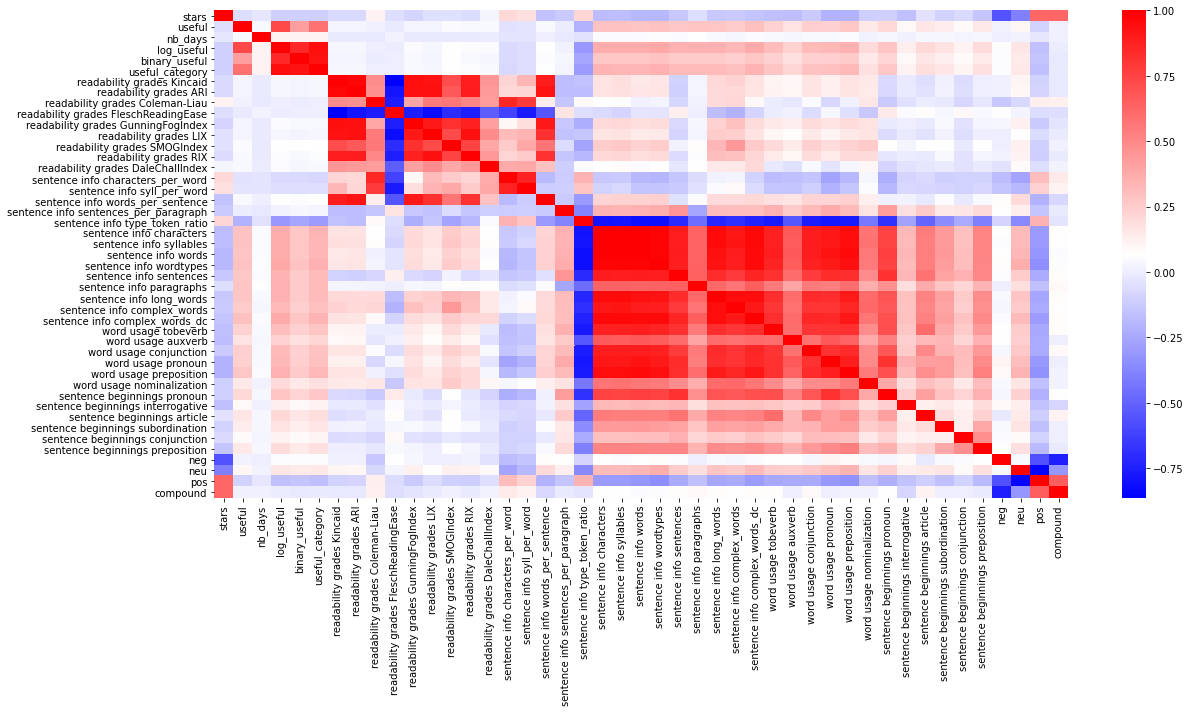

In [42]:
f = plt.figure(figsize = (18,10))
corr = review_df.corr()
ax =sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="bwr")
plt.tight_layout()

/Users/jzmichal/opt/anaconda3/envs/yelpEnv/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


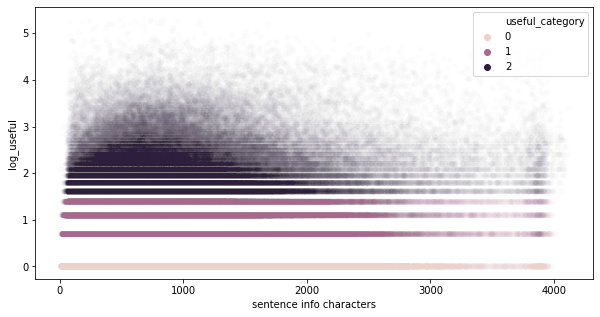

In [22]:
f, ax = plt.subplots(figsize = (10,5))

sns.scatterplot(x = "sentence info characters", y = "log_useful", data = review_df, hue = "useful_category", alpha = .01)

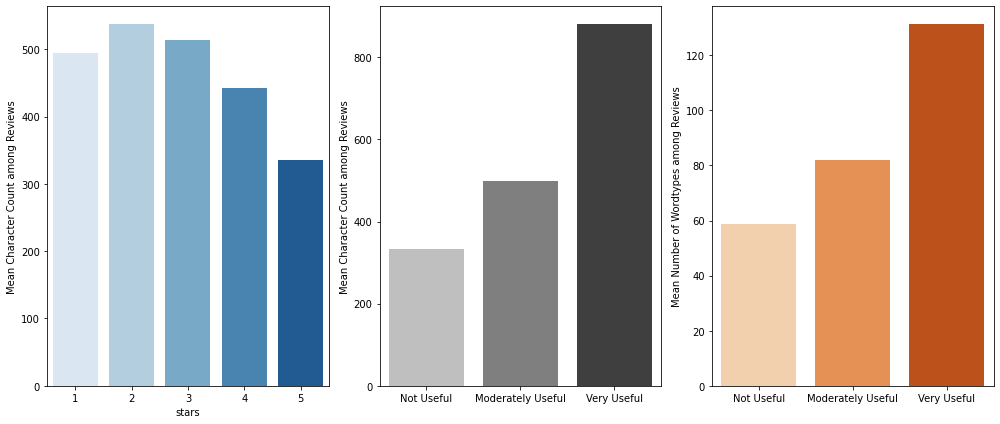

In [23]:
d1 = review_df.groupby(["stars"])["sentence info characters"].mean()
d2 = review_df.groupby(["useful_category"])["sentence info characters"].mean()
d3 = review_df.groupby(["useful_category"])["sentence info wordtypes"].mean()

f,ax = plt.subplots(1,3,figsize = (14,6))

ax0 = sns.barplot(d1.index, d1.values, ax = ax[0], palette="Blues")
ax0.set_ylabel("Mean Character Count among Reviews")

ax1 = sns.barplot(["Not Useful", "Moderately Useful", "Very Useful"], d2.values, ax = ax[1], palette="gist_gray_r")
ax1.set_ylabel("Mean Character Count among Reviews")

ax2 = sns.barplot(["Not Useful", "Moderately Useful", "Very Useful"], d3.values, palette="Oranges")
ax2.set_ylabel("Mean Number of Wordtypes among Reviews")

plt.tight_layout()

No matter how we look at it, there appears to be some correlation between how useful a review is and how long it is. It appears that lower rated reviews have higher average mean word count, along with higher mean log useful votes. Very useful reviews have over double the mean number of characters compared to reviews that received no useful votes (Not Useful).

### Visualizing  Success of Sentiment Analyzer

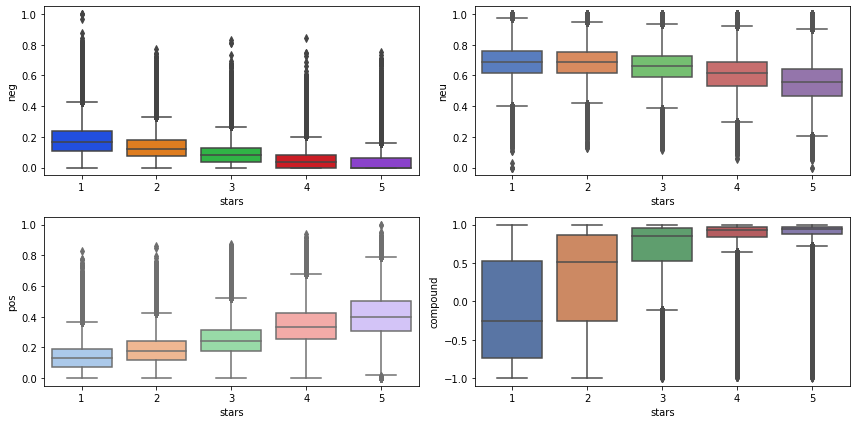

In [24]:
f, axes = plt.subplots(2,2, figsize = (12,6))


ax0 = sns.boxplot(x = "stars", y = "neg", data= review_df, ax = axes[0,0], palette = "bright")

ax1 = sns.boxplot(x = "stars", y = "neu", data= review_df, ax = axes[0,1], palette = "muted")

ax2 = sns.boxplot(x = "stars", y = "pos", data= review_df, ax = axes[1,0], palette = "pastel")

ax3 = sns.boxplot(x = "stars", y = "compound", data= review_df, ax = axes[1,1], palette = "deep")
plt.tight_layout()

These box plots confirm that our sentiment analyzer is working as hoped. Looks like negative and positive both follow the pattern we'd hope to see, showing that lower rated reviews have higher negative sentiment analyses, and higher rated reviews have have positive sentiment analysis. It's a bit harder to tell whats going on with compound and neutral, although they both do appear to follow a trend.

## Examining features that give the best separation


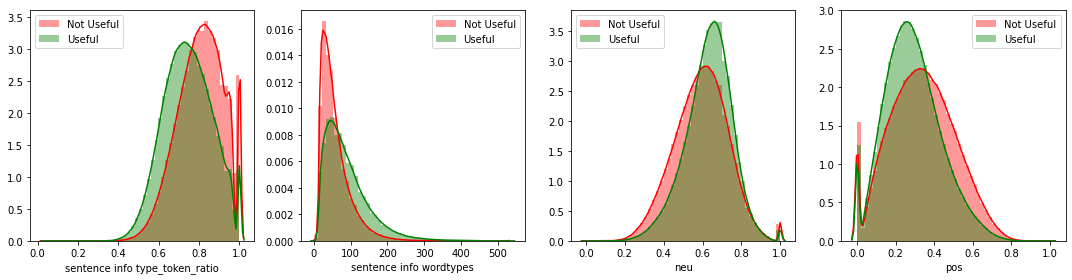

In [25]:
columns = ["sentence info type_token_ratio", "sentence info wordtypes", "neu", "pos"]
f,ax = plt.subplots(1, 4, figsize = (15,4))
i = 0
for col in columns:
    plt.subplot(1, 4, i+1)
    i += 1
    sns.distplot(review_df[col][review_df["binary_useful"] == 0], color='r', label = 'Not Useful')
    sns.distplot(review_df[col][review_df["binary_useful"] == 1], color = "g", label = "Useful")
    plt.legend(loc='best')
f.tight_layout()
plt.show()

After looping through all of the features to examine the distributions with histograms,these were the five features that stood out amoung each category. Among them the features are a readability index, the type token ratio which we defined earlier as the length of the set of words in a review, divided by the number of words used in a given review. So intuitively, reviews that have a higher score of this means that the user has a lot of unique words in their review, where as lower rates means that the user uses a lot of the same words. It looks like reviews with a higher type_token_ratio tend to be not useful, and less so for useful reviews. 

The next observation we can make from these histograms is regarding wordtypes. The not useful reviews is much more dense in terms of having not very many wordtypes, where as useful reviews have more spread out distribution of wordtypes, specifically there are more useful reviews with more wordtypes. 

Finally, our last interesting distributions are with respect to our sentiment analyzer. There are more useful reviews that have a higher neutral rating, and more useful reviews that have a lower positive rating. This goes hand in hand with our analysis earlier that reviews that give lower stars (which would imply a more negative review) tend to be more useful.

***Note that these are just the features that gave the best separation. Nearly all features still demonstrated some degree of separation, especially sentence info and word usage.

## Scatterplots that Demonstrate Separation of Usefulness

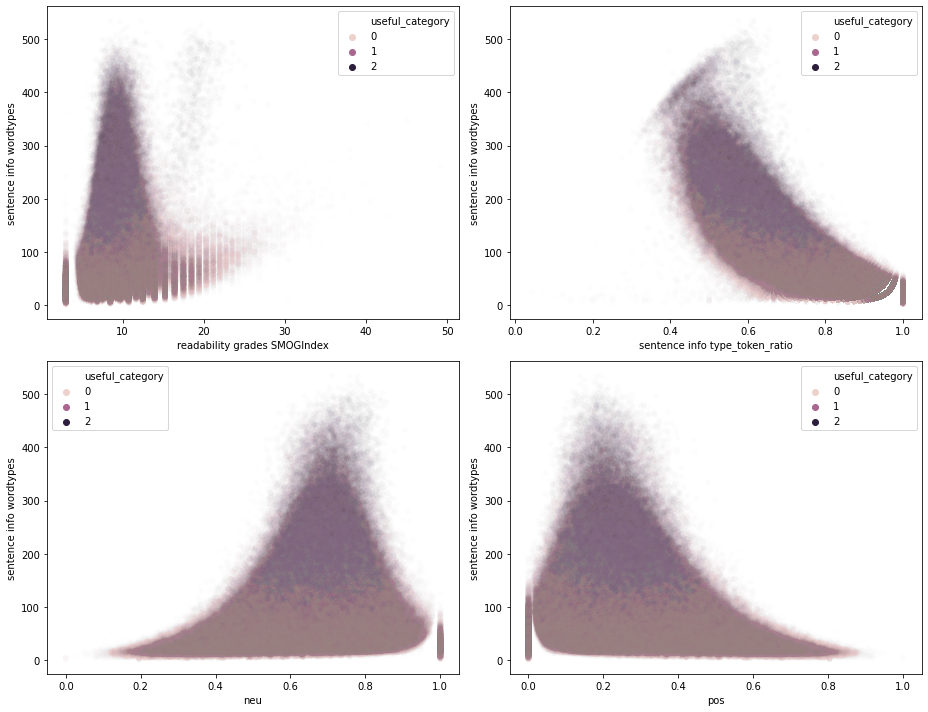

In [26]:
columns = ["readability grades SMOGIndex", "sentence info type_token_ratio", "neu", "pos"]
f, ax = plt.subplots(2,2,figsize = (13,10))
i = 0
for col in columns:
    plt.subplot(2,2,i+1)
    i+=1
    sns.scatterplot(x = col, y = "sentence info wordtypes", hue = "useful_category", data = review_df, alpha = .01)
    plt.legend(loc='best')
f.tight_layout()
plt.show()

First, note that the y variable for all of these scatterplots is wordtypes, the same feature we saw in the block above. Additionally, they are all colored by useful_category, which we defined above as 
0 - Not Useful (no useful votes)
1 - Useful (atleast 1 useful vote)
2 - Very Useful (Calculated to be technical 'outliers' in our data in terms of just how useful they are)

Analyzing the first scatterplot, this is consistent with the scatterplots that we saw before for readability metrics, however this metric is different than the two we visualized earier. Reviews with more wordtypes and having a closer to  average readability rating tend to be more useful. It's interesting that once again we see reviews that receive a higher readability grade and have more wordtypes dont necessilary tend to be more useful.

The second, upper right scatter plot shows a much more negative correlation between the two variables, wordtypes and type_token_ratio. The best part of this plot is the fact that the coloring and negative correlation is consistent with what we saw earlier with our histogram analysis of each of these variables individually. Recall that we saw there was a higher density of useful reviews and more wordtypes, and reviews having a lower type_token_ratio corresponding to being useful. The fact that when we plot these two together and we see still see such separation is promising that these two features when combined have meaning.

The third and fourth scatterplots (the second row) once again confirm what we observed earlier with the histograms. As with our type_token_ratio feature, these neutral and positive features also show that there is some relationship going on between these features and number of wordtypes. Before with the histograms all we saw was that there are more useful reviews that have a higher neutral rating, and more useful reviews that have a lower positive rating. Now we can see additionally that these reviews with more wordtypes are more useful.

### PCA for Feature Selection

In [27]:
numerical_review_features = review_df.drop(columns = ["text","nb_days", "cleaned_review", "useful", 
                              "log_useful", "binary_useful", "useful_category"])
X = MinMaxScaler(feature_range=[0, 1]).fit_transform(numerical_review_features)

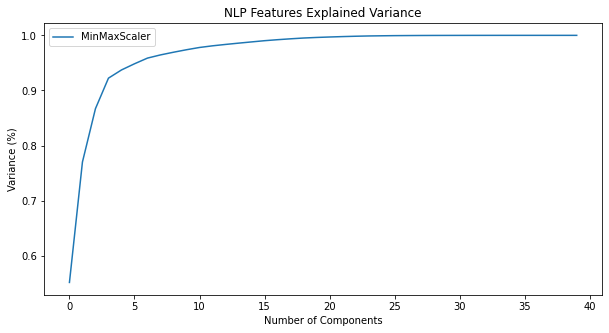

In [28]:
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
f, ax = plt.subplots(figsize = (10,5))


plt.plot(np.cumsum(pca.explained_variance_ratio_), label = "MinMaxScaler")
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('NLP Features Explained Variance')
plt.legend(loc='best')

plt.show()

In [29]:
print("Top 5 MinMaxScaler PCA features and how much variance they explain", pca.explained_variance_ratio_[:5])

Top 5 MinMaxScaler PCA features and how much variance they explain [0.55162347 0.21857023 0.09677453 0.05537079 0.01487109]


Looks like 2 of the new features account for about 70% variance in the data, and the top 5 account for about 87% variance in the data.

In [30]:
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)
X_reduced_df = pd.DataFrame(X_reduced)

In [31]:
review_df.reset_index(inplace = True, drop = True)
X_reduced_df.reset_index(inplace = True, drop = True)
X_reduced_df = X_reduced_df.rename(columns = {0:"PCA_0", 1: "PCA_1"})
new_df = pd.concat([X_reduced_df, review_df], axis = 1)

## Scatterplot of First Two PCA Features Colored by Useful Category

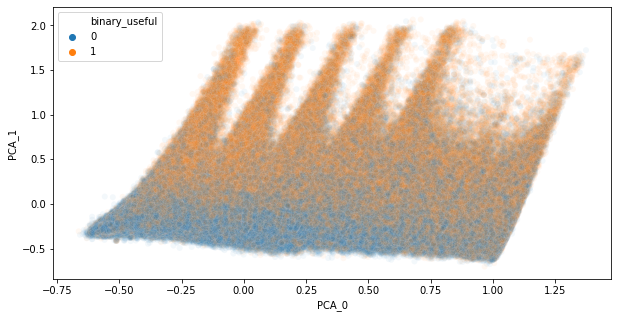

In [32]:
f, ax = plt.subplots(figsize = (10,5))

sns.scatterplot(x = "PCA_0", y = "PCA_1", hue = "binary_useful", data = new_df, alpha=.05)
plt.legend(loc='best')

From the above scatterplot it looks like we have some weird striations among the two most significant PCA features, and a general positive correlation between the two variables that coincides with usefulness when using our binary labeling. 
Let's check out what features each principal component is emphasizing the most by examining the weights each feature is given for both principal components.

## Barchart to Represent Meaning behind PCA Features

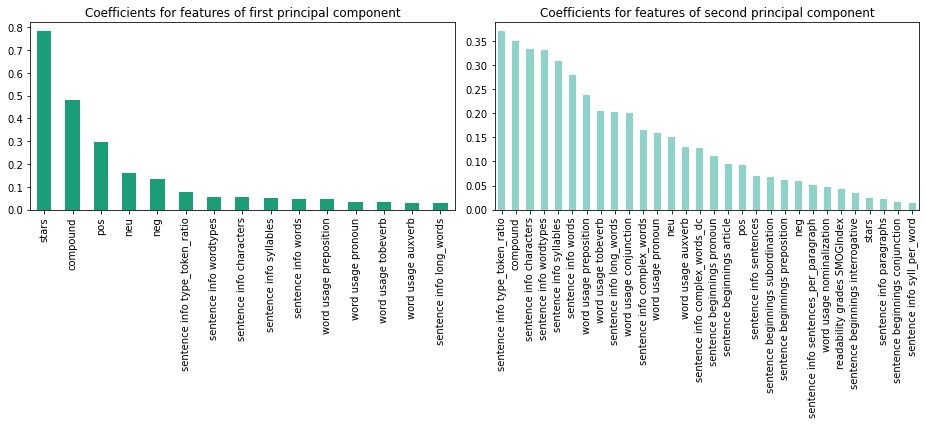

In [33]:
pca_weights_df = pd.DataFrame(pca.components_, columns=list(numerical_review_features.columns))
helper = pca_weights_df.T
pc_0 = helper.iloc[:, 0].apply(lambda x: abs(x)).sort_values(ascending = False)[:15]
pc_1 = helper.iloc[:, 1].apply(lambda x: abs(x)).sort_values(ascending = False)[:30]

f, ax = plt.subplots(1, 2,figsize = (13, 6) )

plt.subplot(121)
ax0 = pc_0.plot(kind = "bar", colormap = "Dark2")
ax0.set_title("Coefficients for features of first principal component")

plt.subplot(122)
ax1 = pc_1.plot(kind = "bar", colormap = "Set3")
ax1.set_title("Coefficients for features of second principal component")

plt.tight_layout()

So it looks like our first principal component is relying heavily on the variance that the star feature gives, along with our sentiment analyzer features of compound, neg, neu, and pos. This actually makes a lot of sense as we showed earlier that these features are and *should* be dependent on eachother, so to see them all working together for this first principal component is exciting. 
Next, it looks like the second principal component relies heavily on our sentence info features, which again we had suspicion that these were important features from our previous findings. 

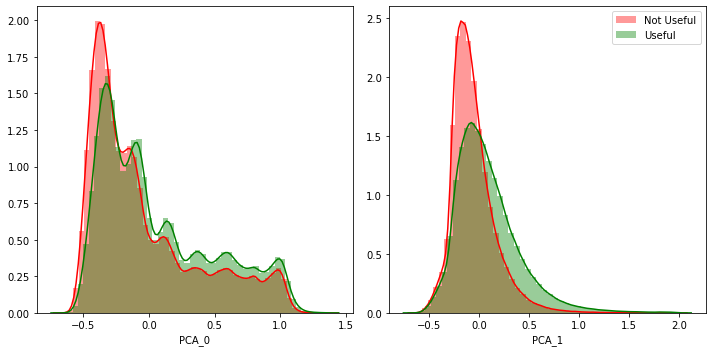

In [34]:
f, ax  = plt.subplots(1, 2, figsize = (10,5))

sns.distplot(new_df["PCA_0"][review_df["binary_useful"] == 0], color='r', label = 'Not Useful', ax = ax[0])
sns.distplot(new_df["PCA_0"][review_df["binary_useful"] == 1], color = "g", label = "Useful", ax = ax[0])

sns.distplot(new_df["PCA_1"][review_df["binary_useful"] == 0], color='r', label = 'Not Useful', ax = ax[1])
sns.distplot(new_df["PCA_1"][review_df["binary_useful"] == 1], color = "g", label = "Useful", ax = ax[1])

plt.legend(loc='best')
f.tight_layout()

We see some separation here with these new features, but nothing more significant than what we already saw with the earlier histograms.

## Scatterplots of Top 2 PCA Features Vs NLP Engineered Features
In general, with our first PCA feature, PCA_0, there is a more variance, which makes sense as the goal of these features is to capture the variance. This captures a little less than 50% of the variance in the data. It's hard to see much of a trend with the coloring by useful category, however there does seem to be negative and postive correlation between PCA_0 and our NLP features.

/Users/jzmichal/opt/anaconda3/envs/yelpEnv/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


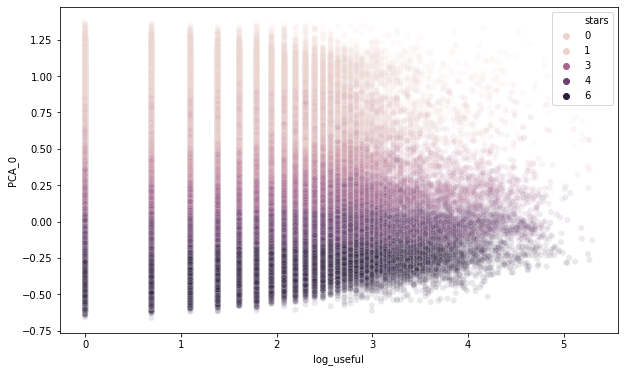

In [35]:
f, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(x = "log_useful", y = "PCA_0", hue = "stars", data = new_df, alpha = .1)
plt.show()

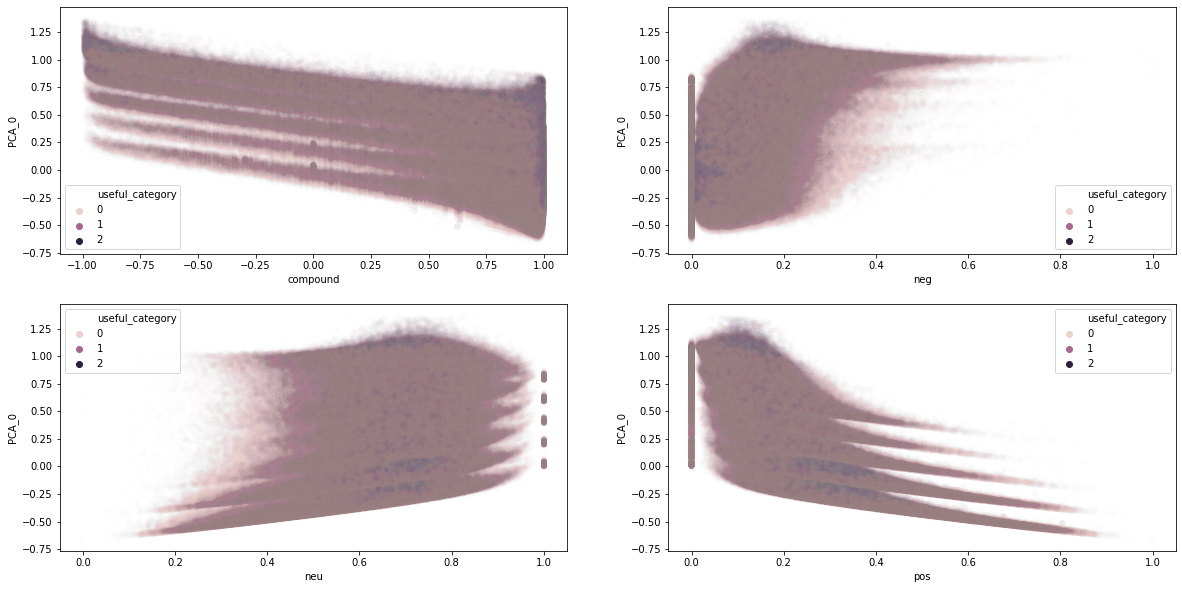

In [36]:
sentiment_cols = ["compound", "neg", "neu", "pos"]
f, ax = plt.subplots(2, 2, figsize = (20,10))
i = 0
for col in sentiment_cols:
    plt.subplot(2,2, i+1)
    i += 1  
    sns.scatterplot(x = col, y = "PCA_0", hue = "useful_category", data = new_df, alpha = .01)
        
plt.show()

Our second PCA feature, captures about 25% of the variance in the data. Here we see much more linear trends as well as the coloring by useful category having much more of an effect.

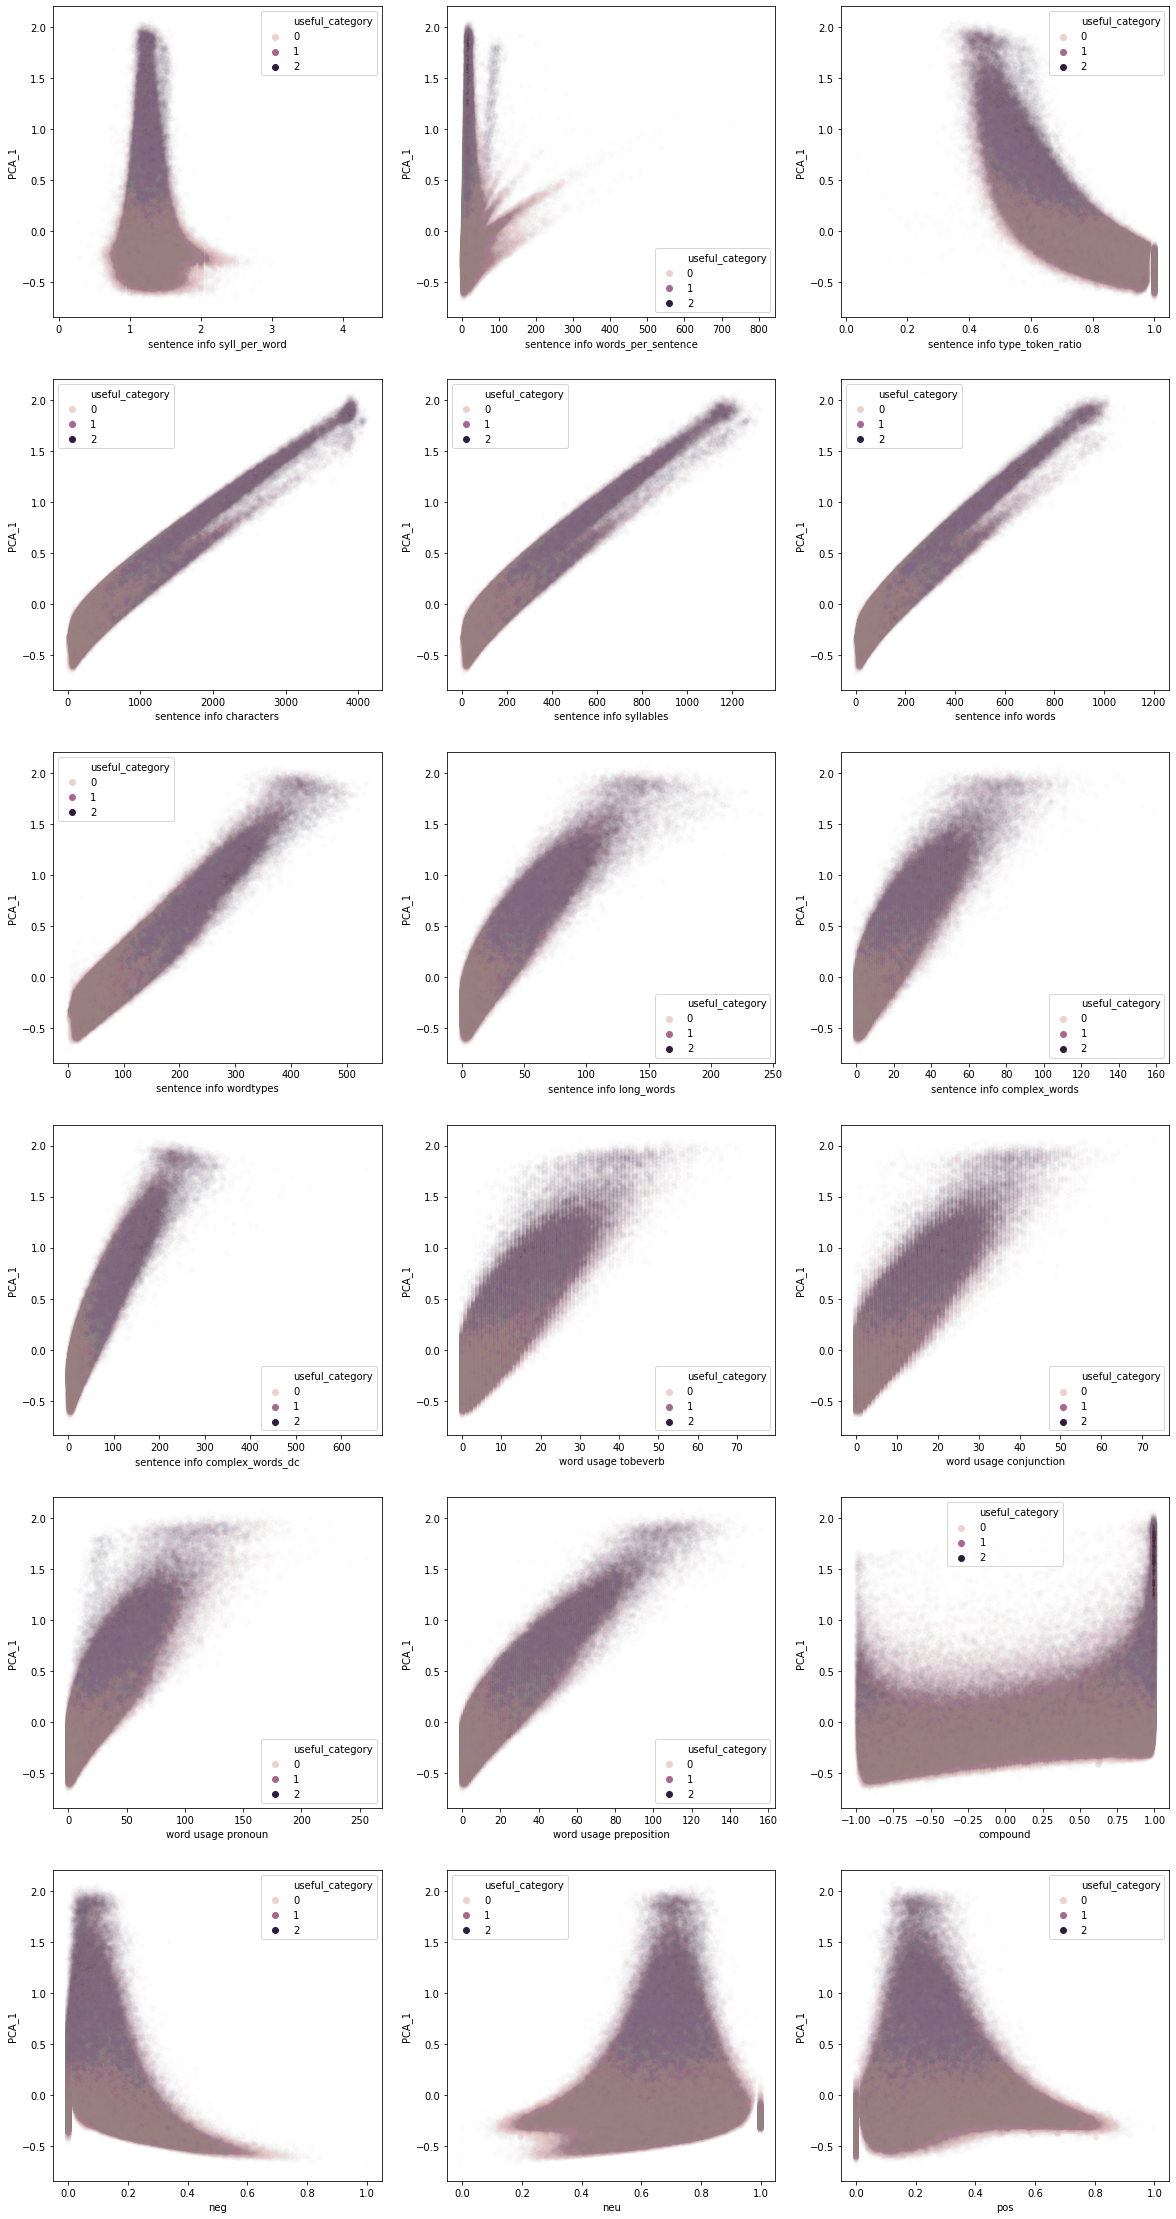

In [37]:
sentence_info_cols = [col for col in review_df.columns if 'sentence info' in col]
word_usage_cols = [col for col in review_df.columns if 'word usage' in col] 
sentiment_cols = ["compound", "neg", "neu", "pos"]

#create list of discrete columns and columns with no correlation with PCA to remove 
#as they aren't helpful to visualize with scatterplots
remove_columns = ["sentence info paragraphs", "sentence info sentences", "sentence info sentences_per_paragraph",
              "sentence info characters_per_word", "word usage auxverb", "word usage nominalization"]
all_cols = sentence_info_cols + word_usage_cols + sentiment_cols
final_columns = list(filter(lambda c:  c not in remove_columns, all_cols))
f, ax = plt.subplots(6, 3, figsize = (20,40))
i = 0
for col in final_columns:
    plt.subplot(6,3, i+1)
    i += 1
    sns.scatterplot(x = col, y = "PCA_1", hue = "useful_category", data = new_df, alpha = .01)
plt.show()

Final Observations: PCA_1 feature appears to have a much stronger correlation with almost every feature, whether it be positive or negative. Specifically, there is a very nice linear trend  with a lot of the sentence info features. The first PCA feature, PCA_0, appears to have some correlation with the compound and positive feature. In the next notebook we'll begin modeling everything

In [38]:
final_df = review_df.drop(columns = ["text","nb_days", "cleaned_review", "useful", "binary_useful", "useful_category"])
final_df.isna().sum()

stars                                    0
log_useful                               0
readability grades Kincaid               0
readability grades ARI                   0
readability grades Coleman-Liau          0
readability grades FleschReadingEase     0
readability grades GunningFogIndex       0
readability grades LIX                   0
readability grades SMOGIndex             0
readability grades RIX                   0
readability grades DaleChallIndex        0
sentence info characters_per_word        0
sentence info syll_per_word              0
sentence info words_per_sentence         0
sentence info sentences_per_paragraph    0
sentence info type_token_ratio           0
sentence info characters                 0
sentence info syllables                  0
sentence info words                      0
sentence info wordtypes                  0
sentence info sentences                  0
sentence info paragraphs                 0
sentence info long_words                 0
sentence in

In [39]:
final_df.to_csv('engineered_df.csv', index=False, encoding='utf-8')